<a href="https://colab.research.google.com/github/pamela-cp/Portfolio-Optimization/blob/main/notebooks/MV_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

      Mean Return  Standard Deviation  Sharpe Ratio
MV         0.0079              0.0421        0.1886
NSMV       0.0089              0.0466        0.1898
MIMV       0.0088              0.0493        0.1794

📊 In-Sample vs Out-of-Sample Comparison Table:
               Metric Strategy  Window (M) In-Sample Out-of-Sample Diff. Out vs In-Sample
                 Mean     MIMV          36    0.880%        1.123%                +0.243%
                 Mean     MIMV          60    0.880%        1.158%                +0.278%
                 Mean     MIMV         120    0.880%        1.193%                +0.313%
                 Mean       MV          36    0.790%        1.092%                +0.302%
                 Mean       MV          60    0.790%        1.163%                +0.373%
                 Mean       MV         120    0.790%        1.240%                +0.450%
                 Mean     NSMV          36    0.890%        1.128%                +0.238%
                 Mean   

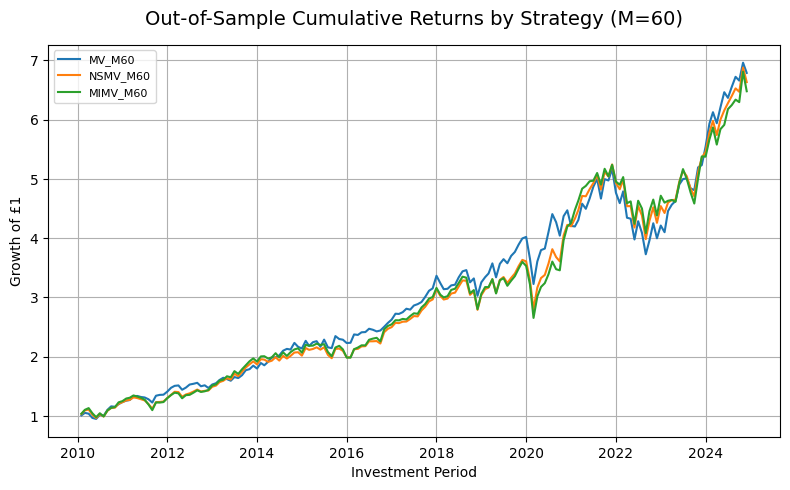

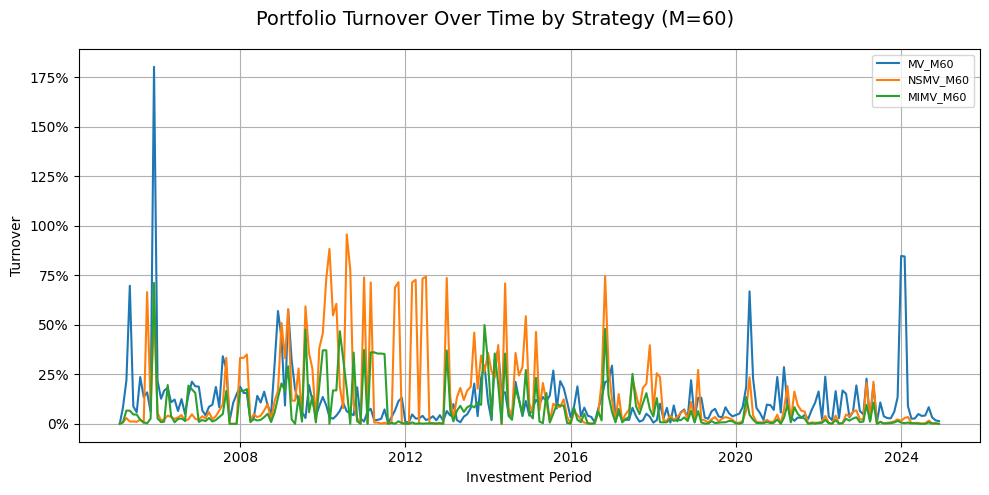

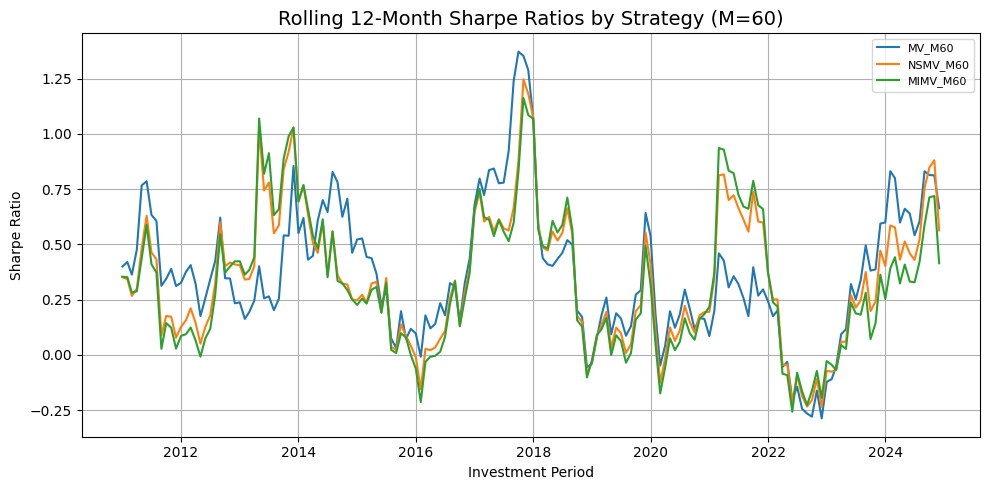

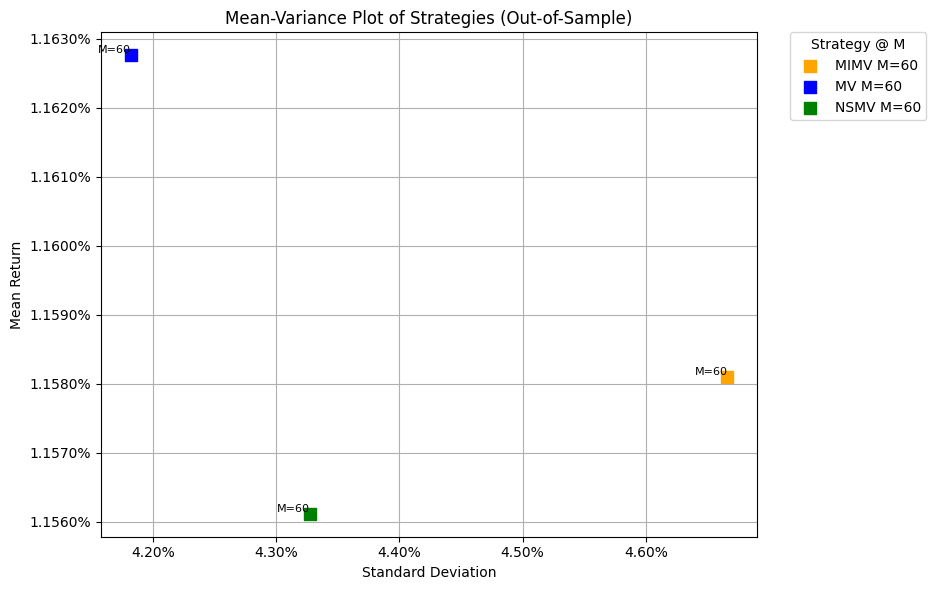

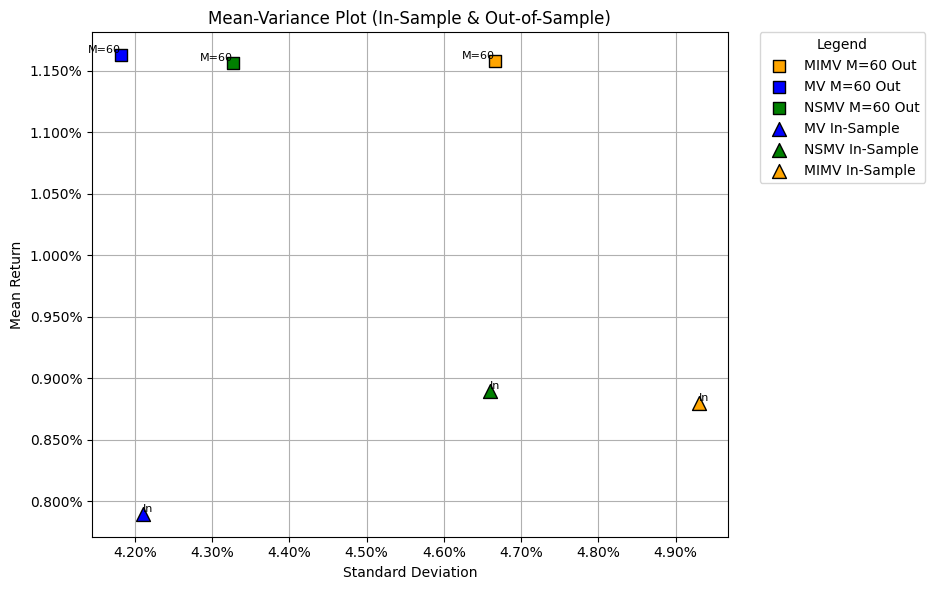

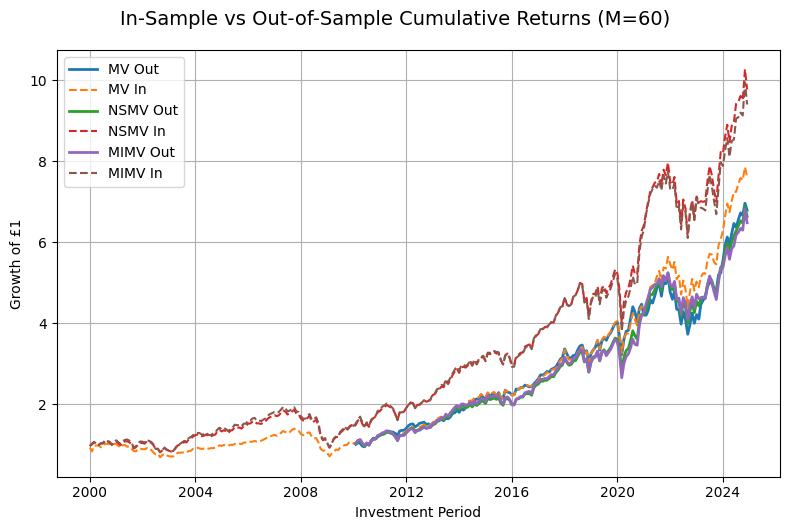

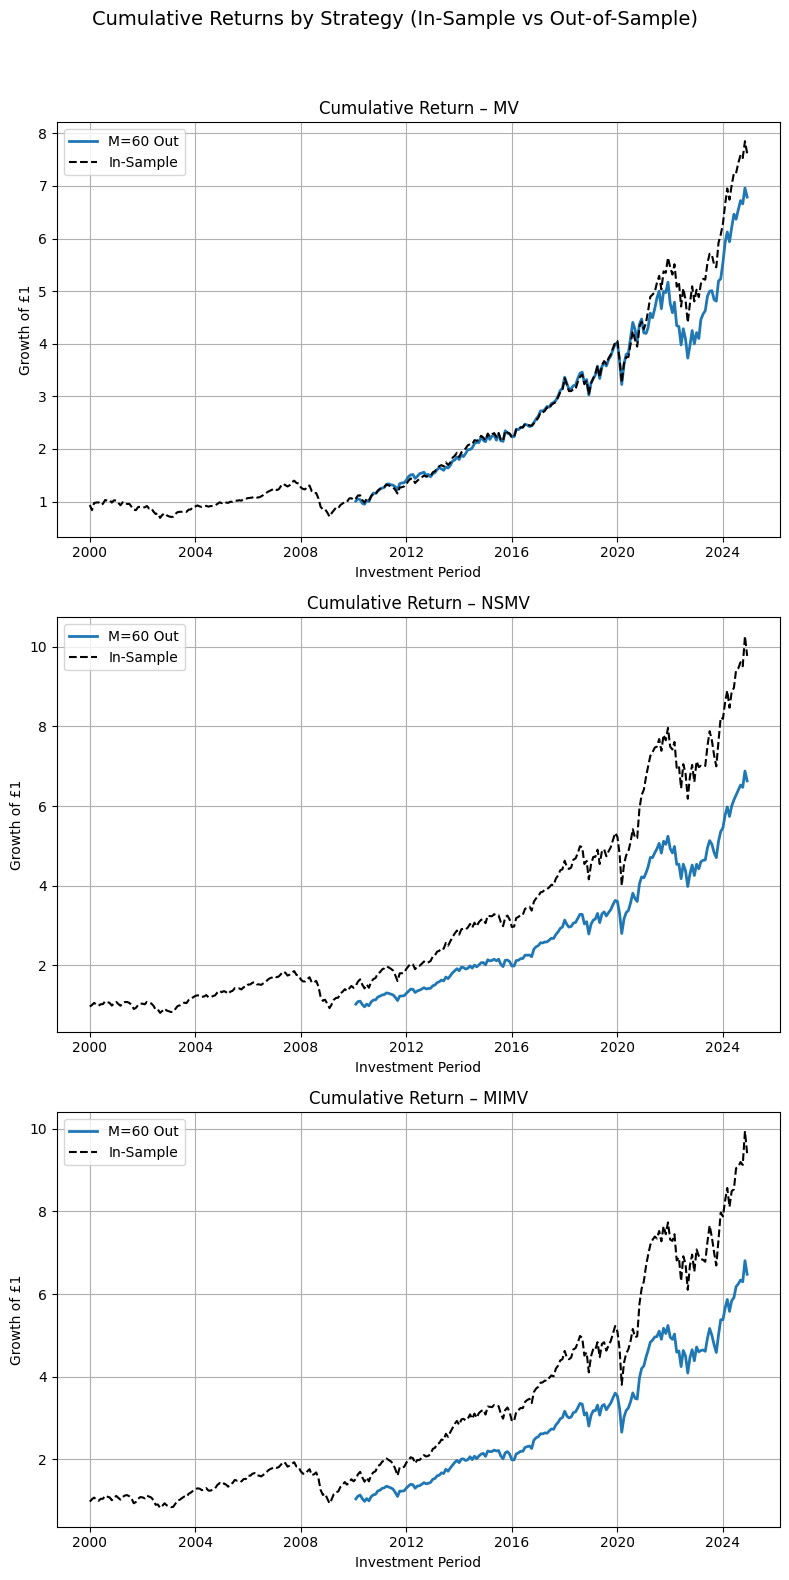

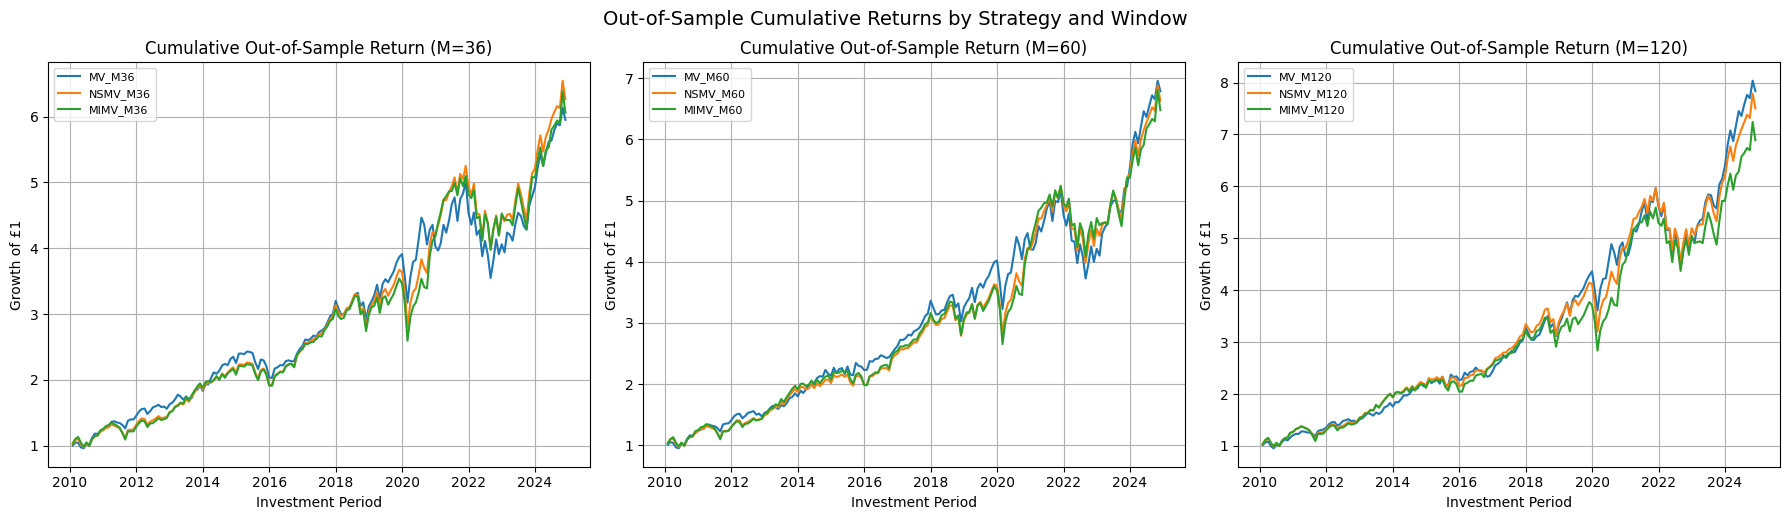

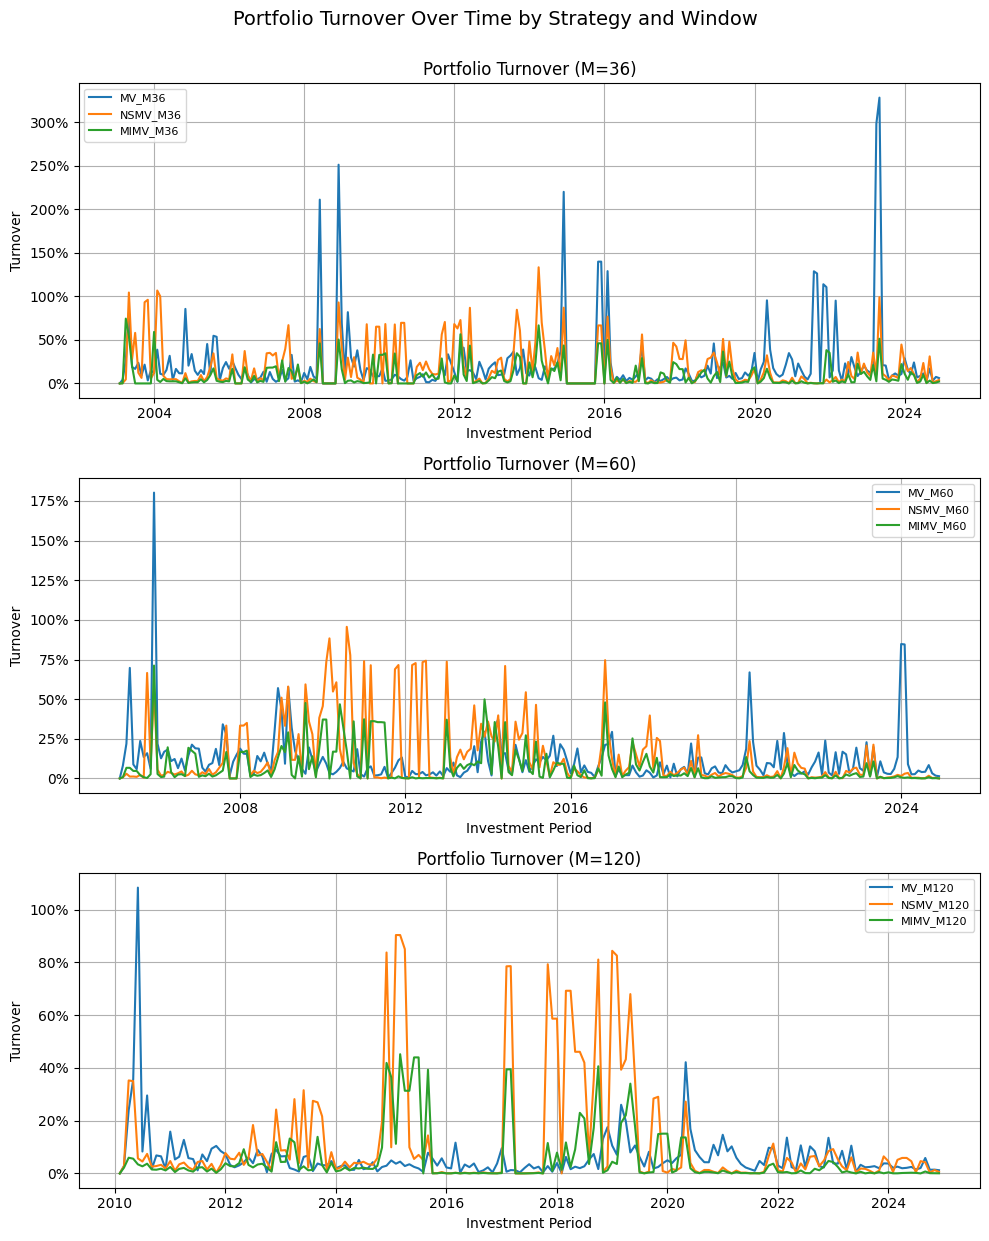

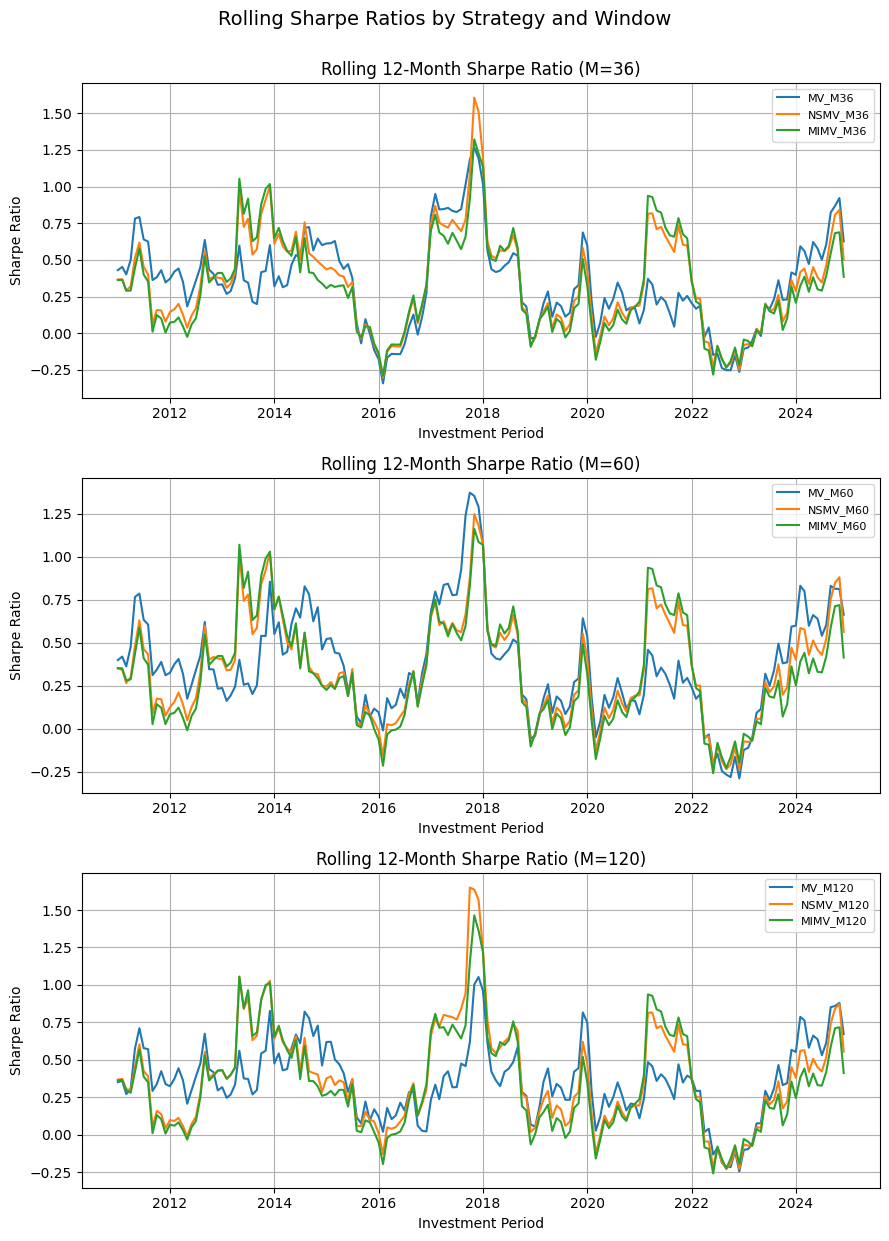

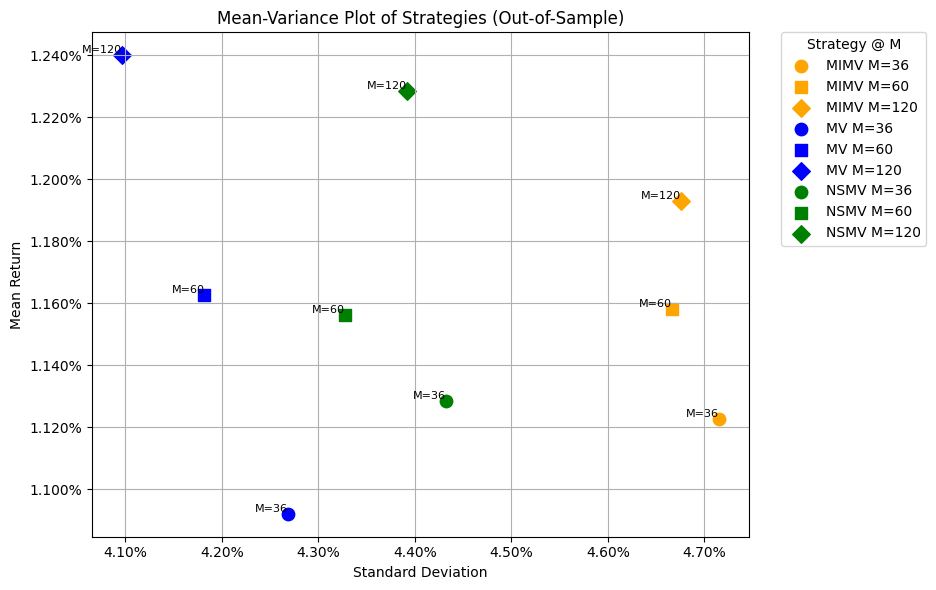

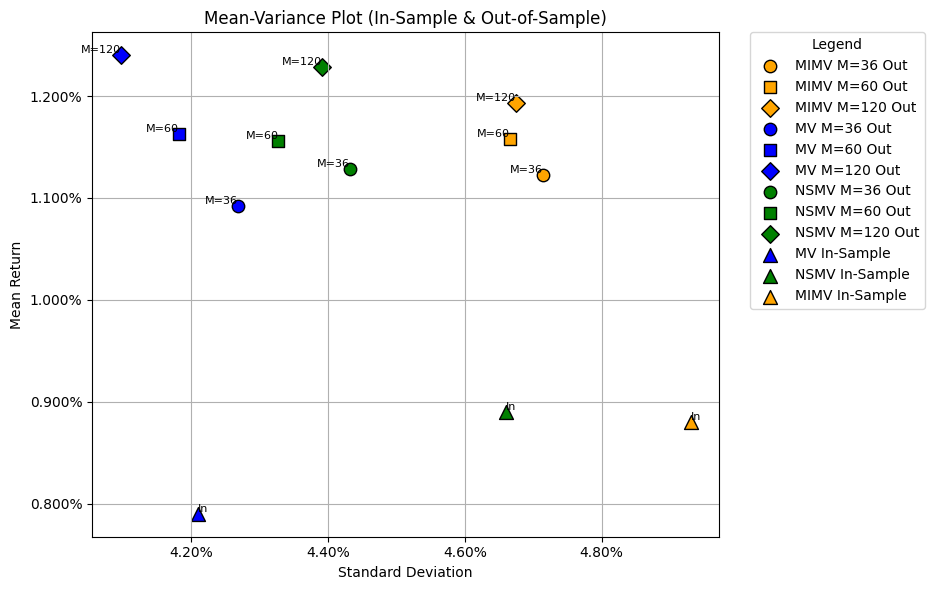

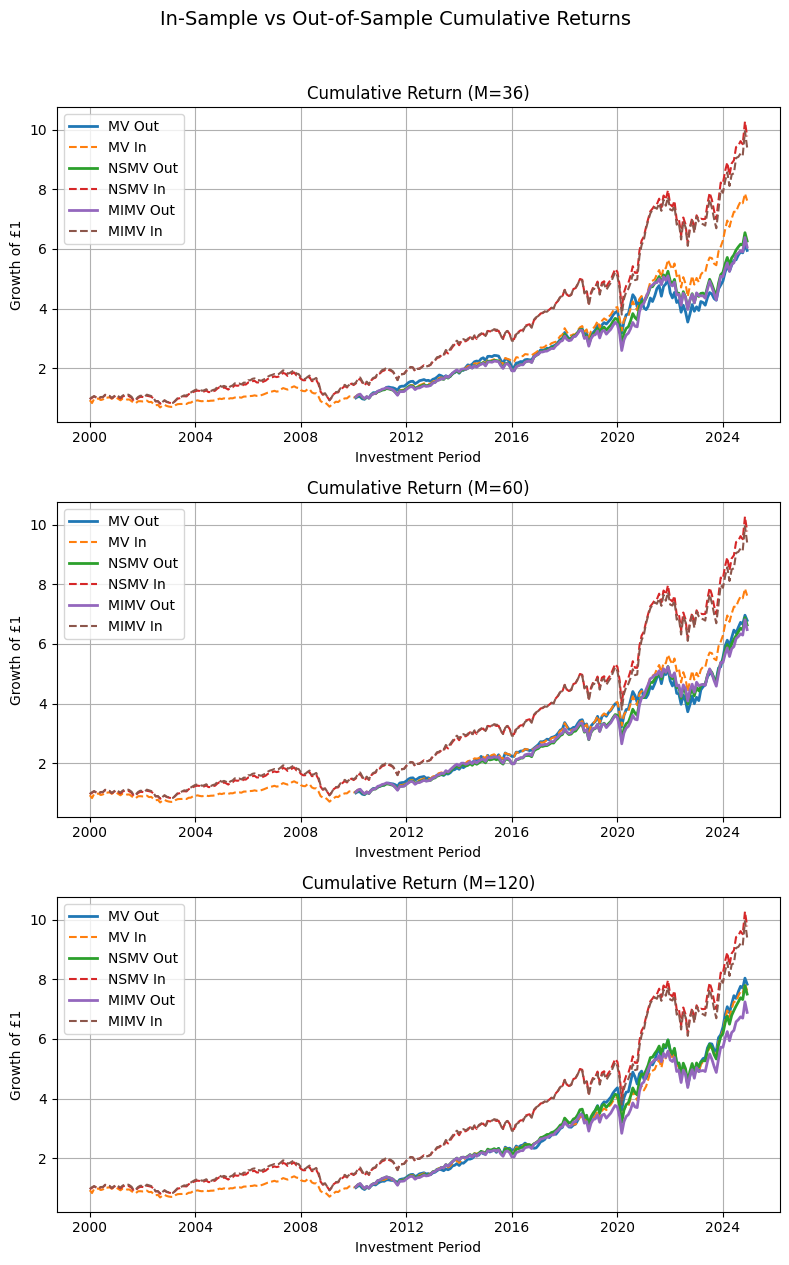

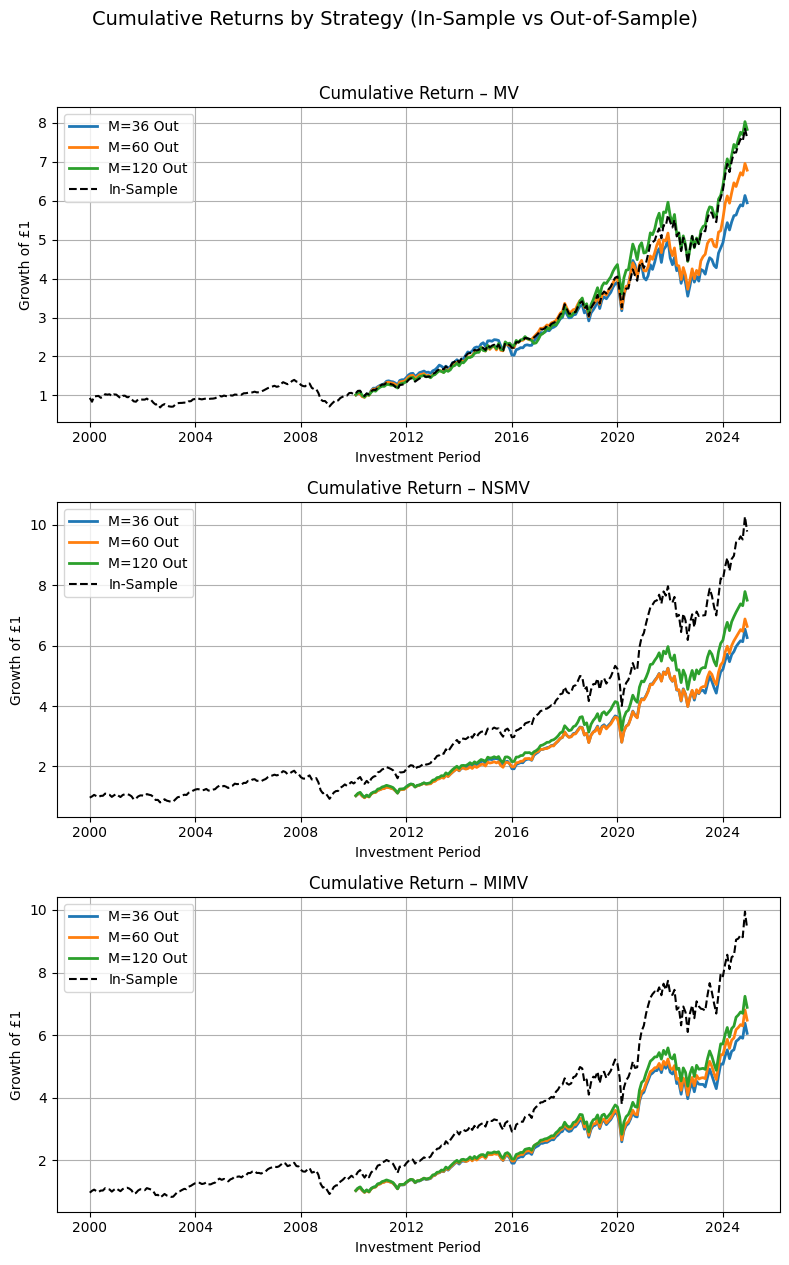

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


In [4]:
import pandas as pd
import numpy as np
import io
from scipy.optimize import minimize, linprog

import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mtick
import requests
from matplotlib.patches import Patch

# === STEP 1: Load and Clean Data ===

# Load sample dataset directly from GitHub
csv_path = "https://raw.githubusercontent.com/pamela-cp/Portfolio-Optimization/main/data/sample/6_Portfolios_2x3_samplefrom2000.csv"

# Fetch file from GitHub
response = requests.get(csv_path)
lines = response.text.splitlines()

target_title = "Average Value Weighted Returns -- Monthly"
start_idx = next(i for i, line in enumerate(lines) if target_title in line)
header = ["Date", "S_LoBM", "S_MedBM", "S_HiBM", "B_LoBM", "B_MedBM", "B_HiBM"]
data_lines = []
for line in lines[start_idx + 2:]:
    clean = line.strip()
    if not clean or not clean.split(",")[0].isdigit():
        break
    data_lines.append(clean)

csv_data = ",".join(header) + "\n" + "\n".join(data_lines)
df = pd.read_csv(io.StringIO(csv_data))
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y%m")
df.set_index("Date", inplace=True)
returns = df / 100
returns = returns["1990":].dropna() # considering data from 1990 to date

# === STEP 2: Utility Functions ===

# Strategies:

    # MV = Mean-Variance (unconstrained)
    # NSMV = No-Short Mean-Variance (weights ≥ 0)
    # MIMV = Minimum-Investment Mean-Variance (weights ≥ 1/(2N))

# Checks whether the target return is feasible under the constraints of a given strategy
def is_feasible(mu, target, strategy):

    N = len(mu)
    A_eq = [np.ones(N)]
    b_eq = [1]
    A_ub = [-mu]
    b_ub = [-target]

    if strategy == "NSMV":
        bounds = [(0, 1)] * N

    elif strategy == "MIMV":
        bounds = [(1 / (2 * N), 1)] * N

    else:
        return True
    res = linprog(c=np.zeros(N), A_ub=A_ub, b_ub=b_ub,
                  A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    return res.success

# Builds general constraints for Optimisation
def build_constraints(strategy, mu, target_return):

    # Portfolio weights sum to 1 (fully invested)
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]

    # Return constraint for NSMV and MIMV: wT*μ≥target
    if strategy != "MV":
        constraints.append({"type": "ineq", "fun": lambda w: w @ mu - target_return})

    return constraints

# Builds lower and upper bound constraints for each asset's weight
def build_bounds(strategy, N):

    # Unconstrained: weights <−∞, + ∞> (allows shorting)
    if strategy == "MV":
        return [(None, None)] * N

    # No-Short: weights ∈ [0, 1]
    elif strategy == "NSMV":
        return [(0, 1)] * N

    # Minimum-Investment: weights ∈ [1/(2N), 1] (forces some diversification)
    elif strategy == "MIMV":
        return [(1 / (2 * N), 1)] * N

strategies = ["MV", "NSMV", "MIMV"]


# === STEP 3: In-Sample Static Optimization ===

# Compute Theoretical benchmark that shows optimal weights without rebalancing

mu_in = returns.mean().values
Sigma_in = returns.cov().values
N = len(mu_in)
target_return_in = mu_in.mean()
in_sample_weights = {}

# Optimisation:

# Objective: Minimize portfolio variance w∧=Σw
# Initial guess: equal weights x0
# Constraints & Bounds: per strategy
# Method: 'SLSQP' (Sequential Least Squares Quadratic Programming)

for strategy in strategies:
    bounds = build_bounds(strategy, N)
    constraints = build_constraints(strategy, mu_in, target_return_in)
    res = minimize(lambda w: w.T @ Sigma_in @ w,
                   x0=np.ones(N) / N,
                   bounds=bounds,
                   constraints=constraints,
                   method="SLSQP")
    # Save the optimal weights if optimization succeeds, otherwise save a NaN vector to signal failure
    in_sample_weights[strategy] = res.x if res.success else np.full(N, np.nan)

# Creates a DataFrame that contains the optimal portfolio weights using the full in-sample data
in_sample_df = pd.DataFrame(in_sample_weights, index=returns.columns)

# === STEP 4: In-Sample Optimization ===

def run_fixed_in_sample(returns, strategy, mu_fixed=None, Sigma_fixed=None, target=None):

    N = returns.shape[1]  # number of assets

    # Computes expected returns mu and covariance matrix Sigma if not provided
    if mu_fixed is None:
        mu_fixed = returns.mean().values
    if Sigma_fixed is None:
        Sigma_fixed = returns.cov().values

    # Use average expected return as target
    if target is None:
        target = mu_fixed.mean()

    returns_series = []  # stores the return at each time t
    weights_series = []  # stores the optimal weights used at each step

    # Goes until len(returns) - 1 so we can compute return at time t+1
    for t in range(len(returns) - 1):

        # Build bounds, constraints and optimise
        bounds = build_bounds(strategy, N)
        constraints = build_constraints(strategy, mu_fixed, target)

        # Optimisation
        # Objective: Minimize portfolio variance w∧=Σw
        # Initial guess: equal weights x0
        # Constraints & Bounds: per strategy
        # Method: 'SLSQP' (Sequential Least Squares Quadratic Programming)

        res = minimize(lambda w: w.T @ Sigma_fixed @ w,
                       x0=np.ones(N) / N,
                       bounds=bounds,
                       constraints=constraints,
                       method="SLSQP")

        # If Optimization Succeeds:
        if res.success:
            w = res.x
            r_next = returns.iloc[t + 1].values @ w
            returns_series.append((returns.index[t + 1], r_next))
            weights_series.append([returns.index[t + 1]] + list(w))

    # Returns a Series of returns and a DataFrame of weights used
    df_returns = pd.Series(dict(returns_series))
    df_weights = pd.DataFrame(weights_series, columns=["Date"] + list(returns.columns)).set_index("Date")
    return df_returns, df_weights

# === Run In-Sample Evaluation ===

# Computes inputs for in-sample optimisation
mu_full = returns.mean().values
Sigma_full = returns.cov().values

# Set target for in-sample optimisation
target_fixed = mu_full.mean()

# Build variables to store results and weights
in_sample_results_fixed = {}
in_sample_weights_fixed = {}

# Call function to in-sample optimisation for each strategy
for strategy in strategies:
    r, w = run_fixed_in_sample(returns, strategy, mu_fixed=mu_full, Sigma_fixed=Sigma_full, target=target_fixed)
    in_sample_results_fixed[strategy] = r
    in_sample_weights_fixed[strategy] = w

# === Summary Metrics ===

# Create a DataFrame with strategy returns
df_in_sample_fixed = pd.DataFrame(in_sample_results_fixed).dropna()

# Compute mean, std, and Sharpe ratio for each strategy
sharpe_in_sample_fixed_df = pd.DataFrame({
    "Mean Return": df_in_sample_fixed.mean(),
    "Standard Deviation": df_in_sample_fixed.std(),
    "Sharpe Ratio": df_in_sample_fixed.mean() / df_in_sample_fixed.std()
}).round(4)

# Print results
print(sharpe_in_sample_fixed_df)


# === STEP 5: Rolling Out-of-Sample Optimization ===

# Use past M months of returns to compute optimal portfolio weights using a selected strategy, and get the next-period return

# returns: full return matrix (post-1990)
# M: rolling window size (36, 60, or 120 months)
# strategy: "MV", "NSMV", or "MIMV"

def run_rolling_outsample(returns, M, strategy):

    N = returns.shape[1] # number of assets
    returns_series = [] # stores the return at each step
    weights_series = [] # stores the optimal weights used at each step

    # Loop per rebalancing time t, starting at M and ending at t-1
    # Starts at month M, because we need M months of data before optimisation
    # Goes until len(returns) - 1 so we can compute return at time t+1
    for t in range(M, len(returns) - 1):

        # Each window starts at t-M, and ends at t-1 for time t
        window = returns.iloc[t - M:t]

        # Estimate expected returns mu and covariance matrix Sigma
        mu = window.mean().values
        Sigma = window.cov().values

        # Skip the iteration if there's missing data
        if np.isnan(mu).any() or np.isnan(Sigma).any():
            continue

        # Use average expected return as target
        target = mu.mean()

        # For constrained strategies, if the target is infeasible, reduce it to 95% of the max expected return to guarantee feasibility
        if strategy in ["NSMV", "MIMV"] and not is_feasible(mu, target, strategy):
            target = mu.max() * 0.95

        # Build bounds and constraints
        bounds = build_bounds(strategy, N)
        constraints = build_constraints(strategy, mu, target)

        # Solve the Optimization Problem
        res = minimize(lambda w: w.T @ Sigma @ w, x0=np.ones(N) / N,
                       bounds=bounds, constraints=constraints, method="SLSQP")

        # If success:
        if res.success:
            w = res.x
            r_next = returns.iloc[t + 1].values @ w

            # Store return and weights
            returns_series.append((returns.index[t + 1], r_next))
            weights_series.append([returns.index[t + 1]] + list(w))

    # Return one-step-ahead returns and the weights used to achieve those returns
    df_returns = pd.Series(dict(returns_series))
    df_weights = pd.DataFrame(weights_series, columns=["Date"] + list(returns.columns)).set_index("Date")
    return df_returns, df_weights

df_out = {} # returns per strategy & window (e.g., "MV_M60")
weights_dict = {} # the actual weights used at each step
all_turnover_data = {}

# Loop over all M and strategies:
for M in [36, 60, 120]:
    for strategy in strategies:
        r, w = run_rolling_outsample(returns, M, strategy)
        key = f"{strategy}_M{M}"
        df_out[key] = r
        weights_dict[key] = w
        turnover = w.diff().abs().sum(axis=1).dropna() # Turnover Calculation at each rebalancing point
        all_turnover_data[key] = {
            "Average Turnover": turnover.mean(),
            "Max Turnover": turnover.max(),
            "Min Turnover": turnover.min()
            }

# Combines all strategies and windows into one DataFrame
df_out = pd.DataFrame(df_out).dropna()

# Standard summary of portfolio performance
sharpe_df = pd.DataFrame({
    "Mean Return": df_out.mean(),
    "Standard Deviation": df_out.std(),
    "Sharpe Ratio": df_out.mean() / df_out.std()
}).round(4)

# Final turnover summary table
turnover_all_M_df = pd.DataFrame(all_turnover_data).T.round(4)
turnover_all_M_df.index.name = "Strategy_Window"

# === STEP 6: Export to Excel ===

# Get base directory (parent of "Python Code")
base_dir = os.path.dirname(os.path.abspath(".")) # Use current directory as base

# Define weights folder path: <base>/results/weights
summary_dir = os.path.join(base_dir, "results", "summary_tables")
os.makedirs(summary_dir, exist_ok=True)

# In-sample outputs
in_sample_path = os.path.join(summary_dir, "in_sample_outputs.xlsx")
with pd.ExcelWriter(in_sample_path, engine="openpyxl") as writer:
    in_sample_df.to_excel(writer, sheet_name="Static Weights")
    for strategy in strategies:
        in_sample_results_fixed[strategy].to_frame(name="Return").to_excel(writer, sheet_name=f"Fixed_returns{strategy}")
        in_sample_weights_fixed[strategy].to_excel(writer, sheet_name=f"Weights_{strategy}")
    sharpe_in_sample_fixed_df.to_excel(writer, sheet_name="Sharpe Summary")

# Full out-of-sample (all windows)
out_sample_path = os.path.join(summary_dir, "out_of_sample_all_windows.xlsx")
with pd.ExcelWriter(out_sample_path, engine="openpyxl") as writer:
    df_out.to_excel(writer, sheet_name="Returns")
    for key, df in weights_dict.items():
        df.to_excel(writer, sheet_name=f"Weights_{key}")
    sharpe_df.to_excel(writer, sheet_name="Sharpe Summary")
    turnover_all_M_df.to_excel(writer, sheet_name="Turnover Summary (All M)")


# === STEP 7: Build summary and Export to Excel ===

# Build comparison of mean, std, Sharpe for in-sample vs out-of-sample across strategies and M

# Define comparison rows
comparison_rows = []

# Loop through each strategy and M
for M in [36, 60, 120]:
    for strategy in strategies:
        key = f"{strategy}_M{M}"

        # Out-of-sample metrics
        try:
            out_returns = df_out[key].dropna()
            out_mean = df_out[key].mean()
            out_std = df_out[key].std()
            out_sharpe = out_mean / out_std if out_std != 0 else np.nan
            out_cum_return = (1 + out_returns).prod() - 1
        except KeyError:
            out_mean, out_std, out_sharpe = np.nan, np.nan, np.nan

        # In-sample metrics (static)
        try:
            in_mean = sharpe_in_sample_fixed_df.loc[strategy, "Mean Return"]
            in_std = sharpe_in_sample_fixed_df.loc[strategy, "Standard Deviation"]
            in_sharpe = sharpe_in_sample_fixed_df.loc[strategy, "Sharpe Ratio"]
            # Cumulative return from static weights
            w_static = in_sample_weights[strategy]
            in_returns = (returns @ w_static).dropna()
            in_cum_return = (1 + in_returns).prod() - 1
        except KeyError:
            in_mean, in_std, in_sharpe = np.nan, np.nan, np.nan

        # Turnover
        try:
            avg_turnover = all_turnover_data[key]["Average Turnover"]
        except KeyError:
            avg_turnover = np.nan

        # Append to summary list
        comparison_rows.append({
            "Strategy": strategy,
            "Window (M)": M,
            "In-Sample Mean": in_mean,
            "Out-of-Sample Mean": out_mean,
            "In-Sample Std": in_std,
            "Out-of-Sample Std": out_std,
            "In-Sample Sharpe": in_sharpe,
            "Out-of-Sample Sharpe": out_sharpe,
            "In-Sample Cumulative Return": out_cum_return,
            "Out-of-Sample Cumulative Return": in_cum_return,
            "Average Turnover": avg_turnover
        })

# Create DataFrame
full_comparison_df = pd.DataFrame(comparison_rows).sort_values(by=["Strategy", "Window (M)"])

# Define the strategy list and windows
windows = [36, 60, 120]


# Compute Differences
full_comparison_df["Mean_Diff"] = full_comparison_df["Out-of-Sample Mean"] - full_comparison_df["In-Sample Mean"]
full_comparison_df["Std_Diff"] = full_comparison_df["Out-of-Sample Std"] - full_comparison_df["In-Sample Std"]
full_comparison_df["Sharpe_Diff"] = full_comparison_df["Out-of-Sample Sharpe"] - full_comparison_df["In-Sample Sharpe"]
full_comparison_df["CumRet_Diff"] = full_comparison_df["Out-of-Sample Cumulative Return"] - full_comparison_df["In-Sample Cumulative Return"]


# Format table like the picture
rows = []

# Mean
for _, row in full_comparison_df.iterrows():
        rows.append(["Mean", row["Strategy"], row["Window (M)"],
                         f'{row["In-Sample Mean"]*100:.3f}%',
                         f'{row["Out-of-Sample Mean"]*100:.3f}%',
                         f'{(row["Mean_Diff"]*100):+.3f}%'])

# Std
for _, row in full_comparison_df.iterrows():
        rows.append(["Std", row["Strategy"], row["Window (M)"],
                     f'{row["In-Sample Std"]*100:.3f}%',
                     f'{row["Out-of-Sample Std"]*100:.3f}%',
                     f'{(row["Std_Diff"]*100):+.3f}%'])

# Sharpe
for _, row in full_comparison_df.iterrows():
        rows.append(["Sharpe Ratio", row["Strategy"], row["Window (M)"],
                     f'{row["In-Sample Sharpe"]:.3f}',
                     f'{row["Out-of-Sample Sharpe"]:.3f}',
                     f'{row["Sharpe_Diff"]:+.3f}'])

# Cumulative Return
for _, row in full_comparison_df.iterrows():
        rows.append(["Cumulative Return (£)", row["Strategy"], row["Window (M)"],
                     f'{row["In-Sample Cumulative Return"]:.3f}',
                     f'{row["Out-of-Sample Cumulative Return"]:.3f}',
                     f'{row["CumRet_Diff"]:+.3f}'])

# Turnover (only Out-of-Sample)
for _, row in full_comparison_df.iterrows():
        rows.append(["Average Turnover", row["Strategy"], row["Window (M)"],
                     "", f'{row["Average Turnover"]*100:.0f}%', ""])

formatted_df = pd.DataFrame(rows,
    columns=["Metric", "Strategy", "Window (M)", "In-Sample", "Out-of-Sample", "Diff. Out vs In-Sample"])


# Create the formatted DataFrame
summary_df = pd.DataFrame(formatted_df)

# Export to Excel
performance_summary_comparison_path = os.path.join(summary_dir, "performance_summary_comparison.xlsx")
with pd.ExcelWriter(performance_summary_comparison_path, engine="openpyxl") as writer:
    summary_df.to_excel(writer, sheet_name="In_vs_Out_Sample_Summary", index=False)

# Optional: Print summary
print("\n📊 In-Sample vs Out-of-Sample Comparison Table:")
print(summary_df.round(4).to_string(index=False))


# === STEP 8: Build plots M=60 ===

# Get base directory (parent of "Python Code")
base_dir = os.path.dirname(os.path.abspath("."))

# Define weights folder path: <base>/results/weights
plots_dir = os.path.join(base_dir, "results", "plots_kpis")
os.makedirs(plots_dir, exist_ok=True)

windows = [60]

# ---------- 8.1. Cumulative Return Plot (Out-of-Sample) ----------

# Plot cumulative out-of-sample returns for all windows side by side

plt.figure(figsize=(8, 5))

for i, M in enumerate(windows, 1):
    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in df_out.columns:
            cumulative = (1 + df_out[key]).dropna().cumprod()
            plt.plot(cumulative.index, cumulative, label=key)

    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    plt.legend(fontsize=8)

    plt.title(f"Out-of-Sample Cumulative Returns by Strategy (M={M})", fontsize=14, y=1.03)
    plt.tight_layout()
    filename = os.path.join(plots_dir, "cumulative_out_of_sample__M60.png")
    plt.savefig(filename)
    plt.show()

# ---------- 8.2. Turnover Over Time (M=60) ----------

def compute_turnover(df_weights):
    return df_weights.diff().abs().sum(axis=1)

for i, M in enumerate(windows, 1):

    plt.figure(figsize=(10, 5))

    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in weights_dict:
            turnover = compute_turnover(weights_dict[key]).dropna()
            plt.plot(turnover.index, turnover, label=key)

    ax = plt.gca()
    ax.set_xlabel("Investment Period")
    ax.set_ylabel("Turnover")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True)
    ax.legend(fontsize=8)

    # Set title using suptitle with adjusted vertical spacing
    plt.suptitle(f"Portfolio Turnover Over Time by Strategy (M={M})", fontsize=14)

    plt.tight_layout()
    filename = os.path.join(plots_dir, f"turnover_over_time_M{M}.png")
    plt.savefig(filename)
    plt.show()

# ---------- 8.3. Rolling Sharpe Ratio (12-month) ----------

def rolling_sharpe(series, window=12):
    return series.rolling(window).mean() / series.rolling(window).std()


for i, M in enumerate(windows, 1):

    plt.figure(figsize=(10, 5))

    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in df_out.columns:
            rs = rolling_sharpe(df_out[key], window=12)
            plt.plot(rs.index, rs, label=key)

    plt.title(f"Rolling 12-Month Sharpe Ratios by Strategy (M={M})", fontsize=14)
    plt.xlabel("Investment Period")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.tight_layout()


    filename = os.path.join(plots_dir, f"rolling_sharpe__M{M}.png")
    plt.savefig(filename)
    plt.show()


# ---------- 8.4. Mean Variance ----------

# Customize colors and markers
colors = {"MV": "blue", "NSMV": "green", "MIMV": "orange"}
markers = {36: "o", 60: "s", 120: "D"}

# Filter only M=60
filtered_df = full_comparison_df[full_comparison_df["Window (M)"] == 60]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each row in the summary DataFrame
for _, row in filtered_df.iterrows():
    strategy = row["Strategy"]
    M = row["Window (M)"]
    mu = row["Out-of-Sample Mean"]
    sigma = row["Out-of-Sample Std"]

    # Only plot if values are finite
    if np.isfinite(mu) and np.isfinite(sigma):
        ax.scatter(sigma, mu,
                    color=colors.get(strategy, "gray"),
                    marker=markers.get(M, "x"),
                    s=80,
                    label=f"{strategy} M={M}")
        # Add label text near the point
        ax.text(sigma, mu, f"M={M}", fontsize=8, ha='right', va='bottom')

# Axis labels and title
ax.set_title("Mean-Variance Plot of Strategies (Out-of-Sample)")
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Mean Return")
ax.grid(True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Build de-duplicated legend and place it outside the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Strategy @ M",
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show
filename = os.path.join(plots_dir, "mean_variance_scatter_M60.png")
plt.savefig(filename, bbox_inches='tight')
plt.show()


# ---------- 8.5. Mean Variance Opt. 2 ----------

# Custom colors and markers
colors = {"MV": "blue", "NSMV": "green", "MIMV": "orange"}
markers = {36: "o", 60: "s", 120: "D"}  # Out-of-sample by M
in_sample_marker = "^"  # Triangle for in-sample

# Filter only M=60
filtered_df = full_comparison_df[full_comparison_df["Window (M)"] == 60]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# --- Plot Out-of-Sample Points ---
for _, row in filtered_df.iterrows():
    strategy = row["Strategy"]
    M = row["Window (M)"]
    mu_out = row["Out-of-Sample Mean"]
    sigma_out = row["Out-of-Sample Std"]

    if np.isfinite(mu_out) and np.isfinite(sigma_out):
        plt.scatter(sigma_out, mu_out,
                    color=colors.get(strategy, "gray"),
                    edgecolor="black",
                    marker=markers.get(M, "x"),
                    s=80,
                    label=f"{strategy} M={M} Out")
        plt.text(sigma_out, mu_out, f"M={M}", fontsize=8, ha='right', va='bottom')

# --- Plot In-Sample Points ---
for strategy in strategies:
    try:
        mu_in = sharpe_in_sample_fixed_df.loc[strategy, "Mean Return"]
        std_in = sharpe_in_sample_fixed_df.loc[strategy, "Standard Deviation"]
        if np.isfinite(mu_in) and np.isfinite(std_in):
            plt.scatter(std_in, mu_in,
                        color=colors.get(strategy, "gray"),
                        edgecolor="black",
                        marker=in_sample_marker,
                        s=100,
                        label=f"{strategy} In-Sample")
            plt.text(std_in, mu_in, "In", fontsize=8, ha='left', va='bottom')
    except KeyError:
        continue

# Finalize plot
ax.set_title("Mean-Variance Plot (In-Sample & Out-of-Sample)")
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Mean Return")
ax.grid(True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Build and place legend outside plot
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(),
          title="Legend",
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.8, 1])
filename = os.path.join(plots_dir, "mean_variance_with_insample_M60.png")
plt.savefig(filename, bbox_inches='tight')
plt.show()

# ---------- 8.6. Cumulative returns ----------

plt.figure(figsize=(8, 5))

for i, M in enumerate(windows, 1):

    has_data = False

    for strategy in strategies:
        key = f"{strategy}_M{M}"

        # Out-of-sample cumulative return
        if key in df_out.columns and not df_out[key].dropna().empty:
            cum_out = (1 + df_out[key].dropna()).cumprod()
            plt.plot(cum_out.index, cum_out, label=f"{strategy} Out", linestyle='-', linewidth=2)
            has_data = True

        # In-sample cumulative return using static weights applied to full data
        try:
            w_static = in_sample_weights[strategy]
            static_returns = returns @ w_static
            cum_in = (1 + static_returns).dropna().cumprod()
            plt.plot(cum_in.index, cum_in, label=f"{strategy} In", linestyle='--', linewidth=1.5)
            has_data = True
        except Exception:
            continue

    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    if has_data:
        plt.legend()

plt.tight_layout()
plt.suptitle(f"In-Sample vs Out-of-Sample Cumulative Returns (M={M})", fontsize=14, y=1.05)
filename = os.path.join(plots_dir, "cumulative_returns_in_vs_out_M60.png")
plt.savefig(filename, bbox_inches="tight")
plt.show()

# ---------- 8.7. Cumulative Returns by Strategy ----------

import matplotlib.pyplot as plt

# Make sure you have:
# - returns: the full return matrix from 1990 onward
# - df_out: out-of-sample returns DataFrame (e.g., MV_M60)
# - in_sample_weights: dictionary of static weights per strategy
# - strategies = ["MV", "NSMV", "MIMV"]

# Create a subplot for each strategy
plt.figure(figsize=(8, 15))

for i, strategy in enumerate(strategies, 1):
    plt.subplot(3, 1, i)
    has_data = False

    # --- Out-of-Sample Cumulative Returns ---
    for M in windows:
        key = f"{strategy}_M{M}"
        if key in df_out.columns and not df_out[key].dropna().empty:
            cum_out = (1 + df_out[key].dropna()).cumprod()
            plt.plot(cum_out.index, cum_out, label=f"M={M} Out", linewidth=2)
            has_data = True

    # --- In-Sample Cumulative Return (Static) ---
    try:
        w_static = in_sample_weights[strategy]
        static_returns = returns @ w_static
        cum_in = (1 + static_returns).dropna().cumprod()
        plt.plot(cum_in.index, cum_in, label="In-Sample", linestyle='--', color="black")
        has_data = True
    except Exception as e:
        print(f"Could not plot in-sample for {strategy}: {e}")

    # --- Final Plot Styling ---
    plt.title(f"Cumulative Return – {strategy}")
    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    if has_data:
        plt.legend()

plt.tight_layout()
plt.suptitle("Cumulative Returns by Strategy (In-Sample vs Out-of-Sample)", fontsize=14, y=1.05)
filename = os.path.join(plots_dir, "cumulative_returns_by_strategy_M60.png")
plt.savefig(filename, bbox_inches="tight")
plt.show()


# === STEP 9: Build plots ALL WINDOWS ===

windows = [36, 60, 120]

# ---------- 9.1. Cumulative Return Plot (Out-of-Sample M=36,60,120) ----------

# Plot cumulative out-of-sample returns for all windows side by side

plt.figure(figsize=(18, 5))

for i, M in enumerate(windows, 1):
    plt.subplot(1, 3, i)
    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in df_out.columns:
            cumulative = (1 + df_out[key]).dropna().cumprod()
            plt.plot(cumulative.index, cumulative, label=key)

    plt.title(f"Cumulative Out-of-Sample Return (M={M})")
    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Out-of-Sample Cumulative Returns by Strategy and Window", fontsize=14, y=1.03)
filename = os.path.join(plots_dir, "cumulative_out_of_sample_all_M.png")
plt.savefig(filename)
plt.show()

# ---------- 9.2. Turnover Over Time (M=36,60,120) ----------

def compute_turnover(df_weights):
    return df_weights.diff().abs().sum(axis=1)

plt.figure(figsize=(10, 12))

for i, M in enumerate(windows, 1):
    ax = plt.subplot(3, 1, i)  # get axis object for subplot
    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in weights_dict:
            turnover = compute_turnover(weights_dict[key]).dropna()
            ax.plot(turnover.index, turnover, label=key)

    ax.set_title(f"Portfolio Turnover (M={M})")
    ax.set_xlabel("Investment Period")
    ax.set_ylabel("Turnover")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Portfolio Turnover Over Time by Strategy and Window", fontsize=14, y=1.03)
filename = os.path.join(plots_dir, "turnover_over_time_all_M.png")
plt.savefig(filename)
plt.show()

# ---------- 9.3. Rolling Sharpe Ratio (12-month) ----------

def rolling_sharpe(series, window=12):
    return series.rolling(window).mean() / series.rolling(window).std()

plt.figure(figsize=(9, 12))

for i, M in enumerate(windows, 1):
    plt.subplot(3, 1, i)
    for strategy in strategies:
        key = f"{strategy}_M{M}"
        if key in df_out.columns:
            rs = rolling_sharpe(df_out[key], window=12)
            plt.plot(rs.index, rs, label=key)

    plt.title(f"Rolling 12-Month Sharpe Ratio (M={M})")
    plt.xlabel("Investment Period")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Rolling Sharpe Ratios by Strategy and Window", fontsize=14, y=1.03)
filename = os.path.join(plots_dir, "rolling_sharpe_all_M.png")
plt.savefig(filename)
plt.show()


# ---------- 9.4. Mean Variance ----------

# Customize colors and markers
colors = {"MV": "blue", "NSMV": "green", "MIMV": "orange"}
markers = {36: "o", 60: "s", 120: "D"}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each row in the summary DataFrame
for _, row in full_comparison_df.iterrows():
    strategy = row["Strategy"]
    M = row["Window (M)"]
    mu = row["Out-of-Sample Mean"]
    sigma = row["Out-of-Sample Std"]

    # Only plot if values are finite
    if np.isfinite(mu) and np.isfinite(sigma):
        ax.scatter(sigma, mu,
                    color=colors.get(strategy, "gray"),
                    marker=markers.get(M, "x"),
                    s=80,
                    label=f"{strategy} M={M}")
        # Add label text near the point
        ax.text(sigma, mu, f"M={M}", fontsize=8, ha='right', va='bottom')

# Axis labels and title
ax.set_title("Mean-Variance Plot of Strategies (Out-of-Sample)")
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Mean Return")
ax.grid(True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Build de-duplicated legend and place it outside the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Strategy @ M",
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show
filename = os.path.join(plots_dir, "mean_variance_scatter_strategies.png")
plt.savefig(filename, bbox_inches='tight')
plt.show()


# ---------- 9.5. Mean Variance Opt. 2 ----------

# Custom colors and markers
colors = {"MV": "blue", "NSMV": "green", "MIMV": "orange"}
markers = {36: "o", 60: "s", 120: "D"}  # Out-of-sample by M
in_sample_marker = "^"  # Triangle for in-sample

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# --- Plot Out-of-Sample Points ---
for _, row in full_comparison_df.iterrows():
    strategy = row["Strategy"]
    M = row["Window (M)"]
    mu_out = row["Out-of-Sample Mean"]
    sigma_out = row["Out-of-Sample Std"]

    if np.isfinite(mu_out) and np.isfinite(sigma_out):
        plt.scatter(sigma_out, mu_out,
                    color=colors.get(strategy, "gray"),
                    edgecolor="black",
                    marker=markers.get(M, "x"),
                    s=80,
                    label=f"{strategy} M={M} Out")
        plt.text(sigma_out, mu_out, f"M={M}", fontsize=8, ha='right', va='bottom')

# --- Plot In-Sample Points ---
for strategy in strategies:
    try:
        mu_in = sharpe_in_sample_fixed_df.loc[strategy, "Mean Return"]
        std_in = sharpe_in_sample_fixed_df.loc[strategy, "Standard Deviation"]
        if np.isfinite(mu_in) and np.isfinite(std_in):
            plt.scatter(std_in, mu_in,
                        color=colors.get(strategy, "gray"),
                        edgecolor="black",
                        marker=in_sample_marker,
                        s=100,
                        label=f"{strategy} In-Sample")
            plt.text(std_in, mu_in, "In", fontsize=8, ha='left', va='bottom')
    except KeyError:
        continue

# Finalize plot
ax.set_title("Mean-Variance Plot (In-Sample & Out-of-Sample)")
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Mean Return")
ax.grid(True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Build and place legend outside plot
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(),
          title="Legend",
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.8, 1])
filename = os.path.join(plots_dir, "mean_variance_with_insample.png")
plt.savefig(filename, bbox_inches='tight')
plt.show()

# ---------- 9.6. Cumulative returns ----------

windows = [36, 60, 120]

plt.figure(figsize=(8, 12))

for i, M in enumerate(windows, 1):
    plt.subplot(3, 1, i)
    has_data = False

    for strategy in strategies:
        key = f"{strategy}_M{M}"

        # Out-of-sample cumulative return
        if key in df_out.columns and not df_out[key].dropna().empty:
            cum_out = (1 + df_out[key].dropna()).cumprod()
            plt.plot(cum_out.index, cum_out, label=f"{strategy} Out", linestyle='-', linewidth=2)
            has_data = True

        # In-sample cumulative return using static weights applied to full data
        try:
            w_static = in_sample_weights[strategy]
            static_returns = returns @ w_static
            cum_in = (1 + static_returns).dropna().cumprod()
            plt.plot(cum_in.index, cum_in, label=f"{strategy} In", linestyle='--', linewidth=1.5)
            has_data = True
        except Exception:
            continue

    plt.title(f"Cumulative Return (M={M})")
    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    if has_data:
        plt.legend()

plt.tight_layout()
plt.suptitle("In-Sample vs Out-of-Sample Cumulative Returns", fontsize=14, y=1.05)
filename = os.path.join(plots_dir, "cumulative_returns_in_vs_out.png")
plt.savefig(filename, bbox_inches="tight")
plt.show()

# ---------- 9.7. Cumulative Returns by Strategy ----------

import matplotlib.pyplot as plt

# Make sure you have:
# - returns: the full return matrix from 1990 onward
# - df_out: out-of-sample returns DataFrame (e.g., MV_M60)
# - in_sample_weights: dictionary of static weights per strategy
# - strategies = ["MV", "NSMV", "MIMV"]

# Create a subplot for each strategy
plt.figure(figsize=(8, 12))

for i, strategy in enumerate(strategies, 1):
    plt.subplot(3, 1, i)
    has_data = False

    # --- Out-of-Sample Cumulative Returns ---
    for M in [36, 60, 120]:
        key = f"{strategy}_M{M}"
        if key in df_out.columns and not df_out[key].dropna().empty:
            cum_out = (1 + df_out[key].dropna()).cumprod()
            plt.plot(cum_out.index, cum_out, label=f"M={M} Out", linewidth=2)
            has_data = True

    # --- In-Sample Cumulative Return (Static) ---
    try:
        w_static = in_sample_weights[strategy]
        static_returns = returns @ w_static
        cum_in = (1 + static_returns).dropna().cumprod()
        plt.plot(cum_in.index, cum_in, label="In-Sample", linestyle='--', color="black")
        has_data = True
    except Exception as e:
        print(f"Could not plot in-sample for {strategy}: {e}")

    # --- Final Plot Styling ---
    plt.title(f"Cumulative Return – {strategy}")
    plt.xlabel("Investment Period")
    plt.ylabel("Growth of £1")
    plt.grid(True)
    if has_data:
        plt.legend()

plt.tight_layout()
plt.suptitle("Cumulative Returns by Strategy (In-Sample vs Out-of-Sample)", fontsize=14, y=1.05)
filename = os.path.join(plots_dir, "cumulative_returns_by_strategy.png")
plt.savefig(filename, bbox_inches="tight")
plt.show()


# ---------- 9.8. Portfolio weights ----------

# Get base directory (parent of "Python Code")
base_dir = os.path.dirname(os.path.abspath("."))

# Define weights folder path: <base>/results/weights
weights_dir = os.path.join(base_dir, "results", "weights")
os.makedirs(weights_dir, exist_ok=True)

# Define strategies and windows
strategies = ["MV", "NSMV", "MIMV"]
windows = [36, 60, 120]
base_colormap = plt.get_cmap("tab20")

def plot_stacked_weights_with_shorts(weights_df, title, save_path, strategy):
    weights_df = weights_df.copy()
    weights_df.index = pd.to_datetime(weights_df.index)

    # Prepare colors for assets
    asset_names = weights_df.columns.tolist()
    colors = [base_colormap(i % 20) for i in range(len(asset_names))]
    asset_color_map = dict(zip(asset_names, colors))

    # Split into long and short
    long_weights = weights_df.clip(lower=0)
    short_weights = weights_df.clip(upper=0)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot long positions
    long_weights.plot.area(
        stacked=True, ax=ax, linewidth=0,
        color=[asset_color_map[col] for col in long_weights.columns],
        legend=False
    )

    # Plot short positions if applicable
    if strategy == "MV":
        short_weights.plot.area(
            stacked=True, ax=ax, linewidth=0,
            color=[asset_color_map[col] for col in short_weights.columns],
            legend=False
        )

    # Title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Weight")
    ax.grid(True)

    # Y-axis limits
    if strategy in ["NSMV", "MIMV"]:
        ax.set_ylim(0, 1.05)
    else:
        max_abs = max(
            abs(long_weights.sum(axis=1).max()),
            abs(short_weights.sum(axis=1).min())
        )
        ax.set_ylim(-max_abs * 1.1, max_abs * 1.1)

    # Add legend matching colors
    legend_patches = [
        Patch(facecolor=asset_color_map[col], label=col, edgecolor="black")
        for col in weights_df.columns
    ]
    ax.legend(handles=legend_patches, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()

# === Plot All Strategies ===

for strategy in strategies:
    # In-sample
    if strategy in in_sample_weights_fixed:
        w_in = in_sample_weights_fixed[strategy]
        save_path = os.path.join(weights_dir, f"{strategy}_in_sample_weights.png")
        plot_stacked_weights_with_shorts(
            w_in,
            title=f"{strategy} In-Sample Portfolio Weights",
            save_path=save_path,
            strategy=strategy
        )

    # Out-of-sample
    for M in windows:
        key = f"{strategy}_M{M}"
        if key in weights_dict:
            w_out = weights_dict[key]
            save_path = os.path.join(weights_dir, f"{strategy}_M{M}_out_sample_weights.png")
            plot_stacked_weights_with_shorts(
                w_out,
                title=f"{strategy} Out-of-Sample Portfolio Weights (M={M})",
                save_path=save_path,
                strategy=strategy
            )
